In [1]:
import scipy.integrate
import pints
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

In [56]:
def load_wolf_moose_data(file_location):
    """Load the Wolves & Moose of Isle Royale data from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the wolf-moose population numbers. The file should contain 
        the year in the first column, no. of moose in the second column, and the no. of wolves in the third column.

    Returns
    -------
    pandas.DataFrame
        Wolves & Moose of Isle Royale
    """
    names = ["year", "wolf", "moose"]
    df = pd.read_csv(file_location, header=None, names=names)
    return df

df = load_wolf_moose_data("wolf_moose_data.csv")
times = df['year'].values
observed_data = df[['wolf', 'moose']].values
init_wolves, init_moose = df['wolf'].iloc[0], df['moose'].iloc[0]

class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_parameters(self):
        return 4

    def simulate(self, parameters, times):
        a, b, c, d = parameters

        def dy(t, state):
            x, y = state
            dx= a * x - b * x * y 
            dy = -c * y + d * x * y
            
            return (dx, dy)

        initial_condition = np.asarray([np.log(30), np.log(4)])

        res = scipy.integrate.solve_ivp(
            dy,
            (times[0], times[-1]),
            initial_condition,
            t_eval=times)
        
        return res.y.T

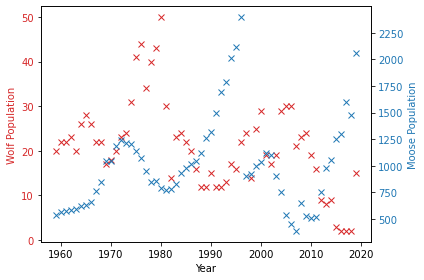

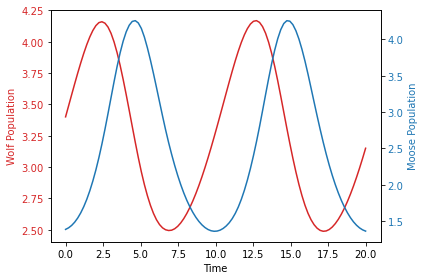

In [57]:
#import pints.toy
#m = pints.toy.LotkaVolterraModel()

# Plot wolf and moose populations
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(df['year'], df['wolf'], 'x', color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(df['year'], df['moose'], 'x', color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

# Make a model object and run a simulation at arbitrary parameter values
m = LotkaVolterraModel()
times = np.linspace(0, 20, 100)
params = [0.28, 0.11, 1.37, 0.42]
#init_wolves, init_moose = 5, 30
#df['wolf'].iloc[0], df['moose'].iloc[0]
y = m.simulate(params, times)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(times, y[:, 0], color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(times, y[:, 1], color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

In [ ]:
class LotkaVolterraLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem):
        super(LotkaVolterraLogLikelihood, self).__init__(problem)

    def __call__(self, parameters):
        # Simulate the model
        simulations = self._problem.evaluate(parameters)
        
        # Calculate the log-likelihood
        error = self._problem.values() - simulations
        log_likelihood = -0.5 * np.sum(error**2)
        
        return log_likelihood

In [ ]:
class Prior(pints.LogPrior):
    def __init__(self):
        super(Prior, self).__init__()
        self.lower = [0, 0, 0, 0]
        self.upper = [2, 2, 2, 2]

    def __call__(self, x):
        if np.any(x < self.lower) or np.any(x > self.upper):
            return -np.inf
        return 0  # Uniform prior

In [ ]:
import pints.residuals_diagnostics

# Step 5: Set up the problem
model = LotkaVolterraModel(init_wolves, init_moose)
problem = pints.MultiOutputProblem(model, times, observed_data)
error = pints.SumOfSquaresError(problem)

# Step 6: Create the log-posterior
log_likelihood = LotkaVolterraLogLikelihood(problem)
log_prior = Prior()
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

opt = pints.OptimisationController(
    error,
    [0.4, 1, 5e5, 2],
    method=pints.CMAES,
    transformation=transformation
)
opt.set_log_interval(200)
found_parameters, found_value = opt.run()

print(found_parameters)

pints.residuals_diagnostics.plot_residuals_autocorrelation(np.asarray([found_parameters]), problem)
plt.show()

pints.residuals_diagnostics.plot_residuals_vs_output(np.asarray([found_parameters]), problem)
plt.show()

In [ ]:
plt.plot(times, y, 'x', label='Data')
plt.plot(times, problem.evaluate(found_parameters[:-2]), label='Model fit', color='k')
plt.legend()
plt.show()
